In [1]:
import numpy as np
import pandas as pd
import json

import requests
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!pip install beautifulsoup4
from bs4 import BeautifulSoup


from sklearn import metrics
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

     |████████████████████████████████| 112kB 22.3MB/s eta 0:00:01


In [2]:
!pip install geopy
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

!pip install folium
# !conda install -c conda-forge folium=0.5.0 --yes
import folium

     |████████████████████████████████| 112kB 25.0MB/s eta 0:00:01


# lets get the information from Barcelona official stats site..

### First the population size
then clean it

In [6]:
source = requests.get('https://www.bcn.cat/estadistica/castella/dades/anuari/cap01/C0101050.htm', verify = False).text
soup = BeautifulSoup(source, 'html.parser')
table = soup.find('table')
rows = table.find_all('tr')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.bcn.cat'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [7]:
pop_bcn = pd.DataFrame(columns = ['Districts','Population 2018','','','',''])
for row in rows:
    cells = row.find_all('td')
    if len(cells)  == 6:
        info = [cell.text for cell in cells]
        pop_bcn.loc[len(pop_bcn)] = info

pop_bcn = pop_bcn[['Districts','Population 2018']]
pop_bcn = pop_bcn.drop([0,1,2,3]).reset_index(drop = True)
for c,district in enumerate(pop_bcn['Districts']):
    pop_bcn.at[c,'Districts'] = district.split('.')[-1]

for c,pop in enumerate(pop_bcn['Population 2018']):
    new_value = pop.split('\xa0\xa0')[0]
    try:
        new_value = int(pop.split('.')[0] + pop.split('.')[1])
    except:
        new_value= int(pop)
    
    if new_value > 80000:
        pop_bcn.drop(c, inplace = True)
    else:
        pop_bcn.at[c,'Population 2018'] = int(new_value)

In [8]:
pop_bcn.reset_index(drop = True,inplace = True)

# Average Price for m2
and clean the set

In [9]:
source = requests.get('https://www.bcn.cat/estadistica/castella/dades/timm/ipreus/habllo/a2019/tbarris2.htm', verify = False).text
soup = BeautifulSoup(source, 'html.parser')
table = soup.find('table')
rows = table.find_all('tr')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.bcn.cat'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


In [10]:
rows = soup.find_all('tr')
m2_bcn = pd.DataFrame(columns = ['Districts','','','','','','','','2019 Average m^2 price €',''])
for row in rows:
    cells = row.find_all('td')
    if len(cells) == 10:
        info = [cell.text for cell in cells]
        m2_bcn.loc[len(m2_bcn)] = info

m2_bcn = m2_bcn[['Districts','2019 Average m^2 price €']]
m2_bcn = m2_bcn.drop([0,1,2,3]).reset_index(drop = True)
for c,name in enumerate(m2_bcn['Districts']):
    new_text = name.split('.')[-1]
    m2_bcn.at[c,'Districts'] = new_text

m2_bcn.reset_index(drop = True, inplace= True)

#### these two are making trouble so we are going to fix them

In [11]:
m2_bcn.at[10,'Districts'] = ' el Poble Sec\xa0\xa0'
m2_bcn.at[11,'Districts'] = ' la Marina del Prat Vermell\xa0\xa0'

## Join both Population and m2 frames
#### and clean a null data.

In [12]:
bcn_data = pd.merge(pop_bcn, m2_bcn, on = 'Districts')
for c, district in enumerate(bcn_data['Districts']):
    name = district.split('\xa0\xa0')[0]
    bcn_data.at[c,'Districts'] = name
for c, city in enumerate(bcn_data['Districts']):
    bcn_data.at[c,'Districts'] = city.lstrip()
    
bcn_data.drop(46,inplace=True)
bcn_data = bcn_data.reset_index(drop=True)

### Im going to add the ditrict-and change name to "Barrios" for better search using the geopy

In [13]:
bcn_data.rename(columns = {'Districts':'Barrios'}, inplace = True)

for i in bcn_data.index:
    if i < 4:
        bcn_data.at[i,'Districts'] = 'Ciutat Vella'
    elif i < 10:
        bcn_data.at[i,'Districts'] = 'Eixample'
    elif i < 18:
        bcn_data.at[i,'Districts'] = 'Sants'
    elif i < 21:
        bcn_data.at[i,'Districts'] = 'Les Corts'
    elif i < 27:
        bcn_data.at[i,'Districts'] = 'Sarrià'
    elif i < 32:
        bcn_data.at[i,'Districts'] = 'Gràcia'
    elif i < 43:
        bcn_data.at[i,'Districts'] = 'Horta'
    elif i < 56:
        bcn_data.at[i,'Districts'] = 'Nou Barris'
    elif i < 63:
        bcn_data.at[i,'Districts'] = 'Sant Andreu'
    elif i < 73:
        bcn_data.at[i,'Districts'] = 'Sant Martí'
        
column_fixer = [bcn_data.columns[-1]] + list(bcn_data.columns[0:-1])
bcn_data = bcn_data[column_fixer]

## Lets get location data from each barrio

In [14]:
from geopy.geocoders import Nominatim

### lets clean some names for search purpose

In [15]:
# location name
bcn_src = bcn_data.copy()
bcn_src.at[16,'Barrios'] = 'Badal'
bcn_src.at[24,'Barrios'] = 'la Bonanova'
bcn_src.at[25,'Barrios'] = 'Galvany'
bcn_src.reset_index(drop=True)
mylist = []
for barrio in bcn_src['Barrios']:
    word1 = barrio.split(' i ')[0]
    word2 = word1.split('-')[0]
    word3 = word2.split(',')[0]
    mylist.append(word3)
    
bcn_src['Barrios'] = mylist

### And run the geopy location module for Latitude and Longitude

this is unreliable function so, i have a error message if it fails.

In [16]:
geolocator = Nominatim(user_agent = 'coursera')
#run = 0
lista = []
for c,(barrio, district) in enumerate(zip(bcn_src['Barrios'], bcn_src['Districts'])):
    #while run = True:
        try:
            city = barrio + ', ' + district + ',Barcelona, España'
            location = geolocator.geocode(city)
            latitude = location.latitude
            longitude = location.longitude
            frase = [c,barrio,latitude,longitude]
            lista.append(frase)
            #print(f' bien --- {c} {barrio} {district}')
            c += 1
        except:
            try:
                palabra = barrio.split(' ')[0] + ' ' + barrio.split(' ')[1]
                city = palabra + ', ' + district + ', Barcelona, España'
                location = geolocator.geocode(city)
                latitude = location.latitude
                longitude = location.longitude
                frase = [c,barrio,latitude,longitude]
                lista.append(frase)
                #print(f' segunda tanda ---{ c} {barrio} {district}')
                c += 1
            except:
                print(f' TRY AGAIN: ERROR IN Row:{ c} - {barrio} {district}')
            #run = False
    

In [17]:
coordenates = pd.DataFrame(lista)
coordenates.drop(columns = 0,inplace = True)
coordenates.rename(columns = {1:'Barrios',2: 'Latitude', 3:'Longitude'}, inplace = True)

## Manually fix a few coordanates for best results

In [18]:
# el parc
coordenates.at[64,'Latitude'] = float(41.399167)
coordenates.at[64,'Longitude'] = float(2.190833)
# galvany
coordenates.at[64,'Latitude'] = float(41.399167)
coordenates.at[64,'Longitude'] = float(2.190833)
# sant andreu
coordenates.at[58,'Latitude'] = float(41.435126)
coordenates.at[58,'Longitude'] = float(2.187543)
# besos
coordenates.at[68,'Latitude'] = float(41.415793)
coordenates.at[68,'Longitude'] = float(2.214653)
# sant pere
coordenates.at[3,'Latitude'] = float(41.386697)
coordenates.at[3,'Longitude'] = float(2.181687)
# raval
coordenates.at[0,'Latitude'] = float(41.380072)
coordenates.at[0,'Longitude'] = float(2.169613)
# sant antoni
coordenates.at[9,'Latitude'] = float(41.378503)
coordenates.at[9,'Longitude'] = float(2.159005)
# putgat
coordenates.at[26,'Latitude'] = float(41.406867)
coordenates.at[26,'Longitude'] = float(2.145158)
# bonanova
coordenates.at[24,'Latitude'] = float(41.407081)
coordenates.at[24,'Longitude'] = float(2.133756)
# montbau
coordenates.at[39,'Latitude'] = float(41.431598)
coordenates.at[39,'Longitude'] = float(2.143078)
# Vall de hebron
coordenates.at[40,'Latitude'] = float(41.430689)
coordenates.at[40,'Longitude'] = float(2.147975)
# sant marti
coordenates.at[70,'Latitude'] = float(41.416978)
coordenates.at[70,'Longitude'] = float(2.197912)
# provecal del poblenou
coordenates.at[69,'Latitude'] = float(41.410955)
coordenates.at[69,'Longitude'] = float(2.204370)

coordenates.drop(columns = 'Barrios', inplace = True)

# Merge data set with coordenates

In [19]:
barcelona_test = pd.concat([bcn_data, coordenates], axis = 1, sort = True)
# fix this name for choropleth uses.
barcelona_test.at[10,'Barrios'] = 'el Poble-sec'

In [20]:
for c,price in enumerate(barcelona_test['2019 Average m^2 price €']):
    number = price.replace(',','.00')
    word = float(number.split('\xa0\xa0')[0])
    barcelona_test.at[c,'2019 Average m^2 price €']  = word

In [21]:
barcelona_test.head()

Districts                                Barrios Population 2018  \
0  Ciutat Vella                               el Raval           46948   
1  Ciutat Vella                         el Barri Gòtic           16731   
2  Ciutat Vella                         la Barceloneta           14739   
3  Ciutat Vella  Sant Pere, Santa Caterina i la Ribera           22296   
4      Eixample                          el Fort Pienc           31922   

  2019 Average m^2 price €   Latitude  Longitude  
0                   14.004  41.380072   2.169613  
1                   14.003  41.383395   2.176912  
2                   17.005  41.380653   2.189927  
3                   15.003  41.386697   2.181687  
4                   13.009  41.395925   2.182325

## Lets make a map preview with barrios location, and population density

In [22]:
location = geolocator.geocode('Barcelona, España')
latitude = location.latitude
longitude = location.longitude

map_bcn = folium.Map(location = [latitude,longitude], zoom_start = 12.5)

In [23]:
# open geojason
with open('barrisfixed2.json') as json_data:
    barrio_data = json.load(json_data)

In [24]:
barcelona_test.head()

Districts                                Barrios Population 2018  \
0  Ciutat Vella                               el Raval           46948   
1  Ciutat Vella                         el Barri Gòtic           16731   
2  Ciutat Vella                         la Barceloneta           14739   
3  Ciutat Vella  Sant Pere, Santa Caterina i la Ribera           22296   
4      Eixample                          el Fort Pienc           31922   

  2019 Average m^2 price €   Latitude  Longitude  
0                   14.004  41.380072   2.169613  
1                   14.003  41.383395   2.176912  
2                   17.005  41.380653   2.189927  
3                   15.003  41.386697   2.181687  
4                   13.009  41.395925   2.182325

In [25]:
threshold_scale = np.linspace(barcelona_test['Population 2018'].min(), barcelona_test['Population 2018'].max(), 6, dtype=int)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

map_bcn.choropleth(
    geo_data=barrio_data,
    data=barcelona_test,
    columns=['Barrios', 'Population 2018'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population 2018',
    reset = True
)


for pop, lat, lng, barrio, district in zip(barcelona_test['Population 2018'], barcelona_test['Latitude'],barcelona_test['Longitude'],barcelona_test['Barrios'],barcelona_test['Districts']):
    try:
        label = (f' {district}, {barrio}. Population = {pop}')
        label = folium.Popup(label, parse_html = True)
        folium.CircleMarker([lat,lng], radius = 5, popup = label, color='blue', fill=True, fill_color='#3186cc', fill_opacity=0.7, parse_html= False).add_to(map_bcn)
    except: 
        print(f'{barrio}')
map_bcn

# Now find the venues for the barrios
## with foursquare api

In [26]:
CLIENT_ID = '2XC45W02YYRHDCWS3IFOONQ13MQDP5N1W5YCJ40MVWQKGWZ1'
CLIENT_SECRET = 'FDD3MIPRZBCJG2LDSE52VHFZ53OJSSETGKTJ5PHPRJUU1WKJ'
VERSION = '20180605'
radius = 700
LIMIT = 250

In [540]:
venues_list5= []
for name, lat, lng in zip(barcelona_test['Barrios'],barcelona_test['Latitude'],barcelona_test['Longitude']):
    try:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()['response']['groups'][0]['items']
        for result in results:
            venues_list5.append([name,lat,lng, result])
    except:
        print('un error')

## I made a list for all the requests to manage it without making more api calls

In [679]:
venues_test = []
for results in venues_list5:
    venues_test.append([(results[0],results[1],results[2],results[3]['venue']['name'],
                         results[3]['venue']['categories'][0]['name'],
                         results[3]['venue']['location']['lat'],
                         results[3]['venue']['location']['lng'],
                         results[3]['venue']['id'],
                        results[3]['venue']['location']['distance'])])

In [581]:
bcn_venues = pd.DataFrame([item for venues_test in venues_test for item in venues_test])
bcn_venues.columns = ['Barrios', 
              'Latitude', 
              'Longitude', 
              'Venue',
                      'Category',
               'Venue lat',
                'Venue lng',
                'Venue ID',
                     'Distance from center']

#### Checking for duplicates, I have 1400 duplicates

In [655]:
bcnlen = len(bcn_venues)
bcnunique = len(bcn_venues['Venue ID'].unique())
print(f' size: {bcnlen} uniques: {bcnunique} ')

 size: 4589 uniques: 3197 


##### Im making two lists to compare them.
##### One in ascending the other in descending, if they match id, then the greater distance will drop

In [656]:
bcn_clean_top = bcn_venues.sort_values('Distance from center', ascending = False)
bcn_clean_top.reset_index(drop = True, inplace = True)

bcn_clean_bt = bcn_venues.sort_values('Distance from center', ascending = True)
bcn_clean_bt.reset_index(drop = True, inplace = True)

In [657]:
for c, (maxdist, idmax) in enumerate(zip(bcn_clean_top['Distance from center'],bcn_clean_top['Venue ID'])):
    for mindist, idmin in zip(bcn_clean_bt['Distance from center'], bcn_clean_bt['Venue ID']):
        if idmax == idmin:
                              if maxdist > mindist:
                                    try:
                                      bcn_clean_top.drop(c, inplace=True)
                                    except:
                                        pass

In [693]:
bcn_clean_top.reset_index(drop=True, inplace = True)

In [694]:
bcnlen = len(bcn_clean_top)
bcnunique = len(bcn_clean_top['Venue ID'].unique())
print(f' size: {bcnlen} uniques: {bcnunique} ')

 size: 3199 uniques: 3197 


#### ill do a save of the data, for avoiding calling the foursquare api

In [31]:
data = pd.read_csv("barcelona_test.csv")
barcelona_test = pd.DataFrame(data)

data = pd.read_csv("Venuesbcn.csv")
bcn_clean = pd.DataFrame(data)

In [32]:
barcelona_test.head(5)

Districts                                Barrios  Population 2018  \
0  Ciutat Vella                               el Raval            46948   
1  Ciutat Vella                         el Barri Gòtic            16731   
2  Ciutat Vella                         la Barceloneta            14739   
3  Ciutat Vella  Sant Pere, Santa Caterina i la Ribera            22296   
4      Eixample                          el Fort Pienc            31922   

   2019 Average m^2 price €   Latitude  Longitude  
0                    14.004  41.380072   2.169613  
1                    14.003  41.383395   2.176912  
2                    17.005  41.380653   2.189927  
3                    15.003  41.386697   2.181687  
4                    13.009  41.395925   2.182325

In [33]:
bcn_clean.head(3)

Barrios   Latitude  Longitude  \
0  Sant Pere, Santa Caterina i la Ribera  41.386697   2.181687   
1      el Parc i la Llacuna del Poblenou  41.399167   2.190833   
2                       el Baix Guinardó  41.411441   2.168510   

             Venue             Category  Venue lat  Venue lng  \
0  Tasca el Corral           Restaurant  41.380452   2.180622   
1     El Cafè Blau                 Café  41.398204   2.182539   
2          Tian Fu  Japanese Restaurant  41.409408   2.176451   

                   Venue ID  Distance from center  
0  4c9bd4acd3c2b60c8d4ab2bc                   700  
1  5268026a498eb8401436933e                   700  
2  4db1e2f943a1bea42bd72fa5                   700

### lets start the heat, one hot coding

In [34]:
bcn_onehot = pd.get_dummies(bcn_clean[['Category']], prefix="", prefix_sep="")
bcn_onehot['Barrios'] = bcn_clean['Barrios']

column_fixer = [bcn_onehot.columns[-1]] + list(bcn_onehot.columns[:-1])
bcn_onehot = bcn_onehot[column_fixer]

In [35]:
bcn_sum = bcn_onehot.groupby('Barrios').mean().reset_index()

In [36]:
bcn_sum = bcn_sum.drop(columns = ['Metro Station', 'Plaza', 'Park'])

In [37]:
bcn_sum.head()

Barrios  Accessories Store  \
0                                 Baró de Viver                0.0   
1                                      Can Baró                0.0   
2                                     Canyelles                0.0   
3                              Ciutat Meridiana                0.0   
4  Diagonal Mar i el Front Marítim del Poblenou                0.0   

   African Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0                 0.0                  0.0           0.0           0.0   
1                 0.0                  0.0           0.0           0.0   
2                 0.0                  0.0           0.0           0.0   
3                 0.0                  0.0           0.0           0.0   
4                 0.0                  0.0           0.0           0.0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  ...  \
0       0.0     0.0               0.0                     0.0  ...   
1       0.0     0.0               0.0                     0.0  ...   
2       0.0     0.0               0.0                     0.0  ...   
3       0.0     0.0               0.0                     0.0  ...   
4       0.0     0.0               0.0                     0.0  ...   

   Video Game Store  Video Store  Vietnamese Restaurant  Wine Bar  Wine Shop  \
0               0.0          0.0                    0.0       0.0        0.0   
1               0.0          0.0                    0.0       0.0        0.0   
2               0.0          0.0                    0.0       0.0        0.0   
3               0.0          0.0                    0.0       0.0        0.0   
4               0.0          0.0                    0.0       0.0        0.0   

   Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  
0     0.0          0.0            0.0          0.0  0.0  
1     0.0          0.0            0.0          0.0  0.0  
2     0.0          0.0            0.0          0.0  0.0  
3     0.0          0.0            0.0          0.0  0.0  
4     0.0          0.0            0.0          0.0  0.0  

[5 rows x 296 columns]

### lets set the top venues quantity

In [38]:
num_venues = 20 #number of venue checked

In [39]:
# rearrange the rows, then take eache row value its index
def common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = num_venues

# name format for columns in new df
indicators = ['st', 'nd', 'rd']
columns = ['Barrios']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#new df with columns for the last code
bcn_sorted = pd.DataFrame(columns=columns)
bcn_sorted['Barrios'] = bcn_sum['Barrios']

#paste thae values from previous fx
for ind in np.arange(bcn_sum.shape[0]):
    bcn_sorted.iloc[ind, 1:] = common_venues(bcn_sum.iloc[ind, :], num_top_venues)

In [41]:
Barrios = bcn_sorted.copy()

## Lets cluster this up

#### ill make some copies that ill use later

In [42]:
barcelona_test.sort_values('Barrios',inplace =True)
join = barcelona_test.copy()
join =  join.join(bcn_sum.set_index('Barrios'), on = 'Barrios')
join['Population 2018'] = join['Population 2018'].astype(int)
join['2019 Average m^2 price €'] = join['2019 Average m^2 price €'].astype(int)
whole = join.copy()
join = join.drop(columns = ['Barrios','Districts','Latitude','Longitude'])
plotjoin = barcelona_test.copy()

In [44]:
bcn_sorted.head()

Barrios 1st Most Common Venue  \
0                                 Baró de Viver        Breakfast Spot   
1                                      Can Baró    Spanish Restaurant   
2                                     Canyelles                Market   
3                              Ciutat Meridiana           Supermarket   
4  Diagonal Mar i el Front Marítim del Poblenou             Beach Bar   

  2nd Most Common Venue     3rd Most Common Venue     4th Most Common Venue  \
0            Kids Store            Clothing Store              Perfume Shop   
1          Soccer Field             Grocery Store                      Pool   
2          Soccer Field                      Café  Mediterranean Restaurant   
3         Train Station                      Café  Mediterranean Restaurant   
4            Restaurant  Mediterranean Restaurant        Athletics & Sports   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0      Asian Restaurant            Shoe Store             Pet Store   
1                   Bar                Bakery                  Café   
2                   Zoo  Fast Food Restaurant   Filipino Restaurant   
3         Grocery Store      Department Store           Flea Market   
4                 Hotel    Italian Restaurant                 Beach   

  8th Most Common Venue 9th Most Common Venue  ... 11th Most Common Venue  \
0           Men's Store            Restaurant  ...           Dessert Shop   
1      Tapas Restaurant        Scenic Lookout  ...           Dessert Shop   
2     Fish & Chips Shop           Fish Market  ...    Fried Chicken Joint   
3  Fast Food Restaurant   Filipino Restaurant  ...      Fish & Chips Shop   
4    Spanish Restaurant                  Café  ...            Beer Garden   

  12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0          Deli / Bodega            Coffee Shop      Fish & Chips Shop   
1         Soccer Stadium          Historic Site     Chinese Restaurant   
2            Flower Shop                   Food      Food & Drink Shop   
3           Cupcake Shop            Fish Market            Flower Shop   
4              Cafeteria            Coffee Shop           Cocktail Bar   

  15th Most Common Venue 16th Most Common Venue 17th Most Common Venue  \
0    Filipino Restaurant   Fast Food Restaurant         Farmers Market   
1            Flea Market            Fish Market      Fish & Chips Shop   
2             Food Court             Food Truck       Football Stadium   
3          Design Studio                   Food      Food & Drink Shop   
4     Seafood Restaurant        Thai Restaurant   Fast Food Restaurant   

  18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  
0            Flea Market            Fish Market            Flower Shop  
1    Filipino Restaurant   Fast Food Restaurant            Flower Shop  
2               Fountain         Farmers Market                   Farm  
3             Food Court             Food Truck       Football Stadium  
4            Flea Market                 Buffet                 Circus  

[5 rows x 21 columns]

# I'm going to try some clustring to find the best cluster.
### First lets use the Population, m2 "2" and venues for clustering 

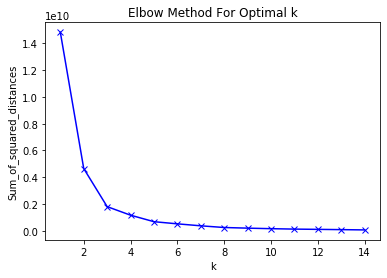

In [45]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(join)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [344]:
kclusters = 5
kmeans = KMeans(n_clusters = kclusters, random_state=0,).fit(join)
labels = (kmeans.labels_)
kmeans.labels_

array([2, 4, 4, 0, 0, 2, 3, 3, 2, 3, 3, 1, 0, 4, 4, 4, 0, 3, 2, 0, 4, 1,
       0, 4, 0, 2, 0, 4, 1, 4, 2, 3, 0, 1, 3, 4, 0, 4, 1, 1, 1, 1, 0, 0,
       0, 4, 4, 1, 4, 4, 0, 1, 1, 4, 1, 4, 1, 4, 2, 0, 4, 0, 3, 0, 4, 4,
       3, 4, 0, 0, 0, 0], dtype=int32)

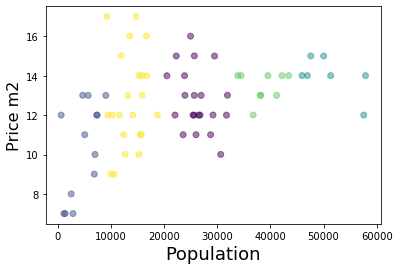

In [345]:
X = join.values[:,:] 
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.5)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Price m2', fontsize=16)

plt.show()

### Then cluster population and venues

In [337]:
pop_venues = join.copy()
pop_venues.drop('2019 Average m^2 price €',axis = 1, inplace =True)

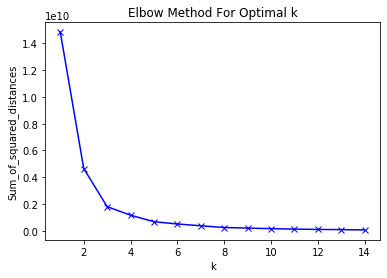

In [338]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(pop_venues)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [339]:
kclusters = 3
kmeans = KMeans(n_clusters = kclusters, random_state=0,).fit(pop_venues)
labels = (kmeans.labels_)
kmeans.labels_

array([2, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 0, 0, 2, 2, 0, 1, 1,
       0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 0, 1, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1,
       0, 1, 0, 0, 0, 0], dtype=int32)

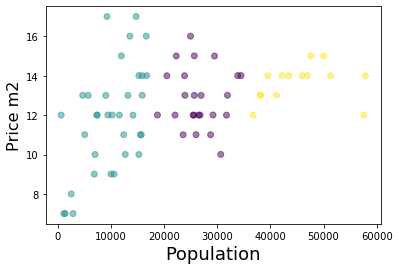

In [340]:
X = join.values[:,:] 
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.5)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Price m2', fontsize=16)

plt.show()

### Lets cluster only using m2 and  venues (This is the one selected)

In [46]:
m2_venues = join.copy()
m2_venues.drop('Population 2018',axis = 1, inplace =True)

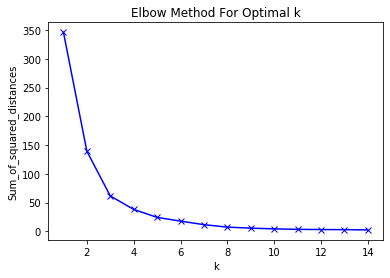

In [47]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(m2_venues)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [48]:
kclusters = 3
kmeans = KMeans(n_clusters = kclusters, random_state=0,).fit(m2_venues)
labels = (kmeans.labels_)
kmeans.labels_

array([0, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 1,
       0, 0, 1, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 2, 1, 2, 2, 0, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 0, 2,
       2, 1, 1, 1, 2, 1], dtype=int32)

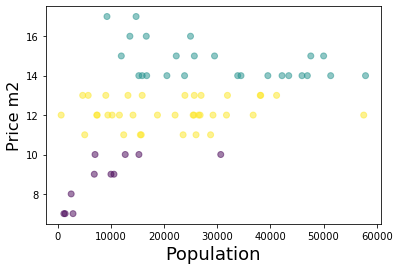

In [75]:
X = join.values[:,:] 
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.5)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Price m2', fontsize=16)

plt.show()

In [49]:
plotjoin['Groups'] = labels

location = geolocator.geocode('Barcelona, España')
latitude = location.latitude
longitude = location.longitude

map_bcn = folium.Map(location = [latitude,longitude], zoom_start = 12.5)

threshold_scale = np.linspace(plotjoin['Population 2018'].min(), plotjoin['Population 2018'].max(), 6, dtype=int)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

map_bcn.choropleth(
    geo_data=barrio_data,
    data=barcelona_test,
    columns=['Barrios', 'Population 2018'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population 2018',
    reset = True
)




# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, district in zip(plotjoin['Latitude'], plotjoin['Longitude'], plotjoin['Barrios'], plotjoin['Groups'], plotjoin['Districts']):
    label = (f'{cluster} {district}, {poi}')
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_bcn)
       
map_bcn

###  Lets cluster population and venues

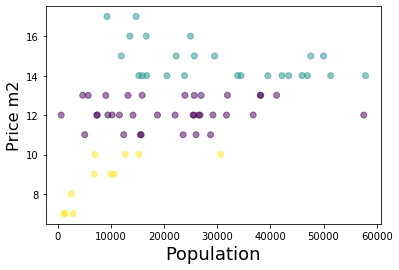

In [328]:
X = join.values[:,:] 
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.5)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Price m2', fontsize=16)

plt.show()

###  lets make one clustering without population and price m2

In [280]:
venues_cluster = join.copy()
venues_cluster.drop(columns = ['Population 2018', '2019 Average m^2 price €'], inplace =  True)

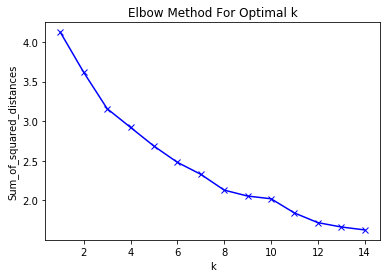

In [281]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(venues_cluster)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [287]:
kclusters = 5
kmeans = KMeans(n_clusters = kclusters, random_state=0,).fit(venues_cluster)
labels = (kmeans.labels_)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

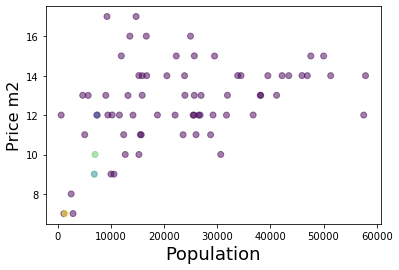

In [288]:
X = join.values[:,:] 
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.5)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Price m2', fontsize=16)

plt.show()

### this isnt right, so im going to use the top 20 general venues to make the clustering more effective with venues

In [297]:
topnames = pd.DataFrame(bcn_sum.sum())
topnames.drop('Barrios',inplace = True)
topnames.sort_values(0,ascending = False, inplace=True)
top_columns

array(['Spanish Restaurant', 'Tapas Restaurant', 'Restaurant',
       'Mediterranean Restaurant', 'Café', 'Grocery Store', 'Bakery',
       'Hotel', 'Supermarket', 'Pizza Place', 'Bar', 'Breakfast Spot',
       'Soccer Field', 'Coffee Shop', 'Italian Restaurant',
       'Burger Joint', 'Gym / Fitness Center', 'Gym',
       'Japanese Restaurant', 'Hostel'], dtype=object)

In [299]:
venues20 = join.copy()
venues20 = venues20[top_columns]

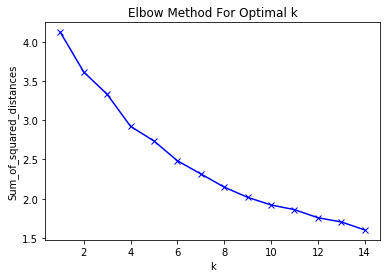

In [301]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(venues_cluster)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [304]:
kclusters = 4
kmeans = KMeans(n_clusters = kclusters, random_state=0,).fit(venues_cluster)
labels = (kmeans.labels_)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

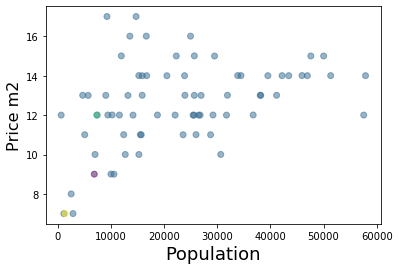

In [305]:
X = join.values[:,:] 
plt.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.5)
plt.xlabel('Population', fontsize=18)
plt.ylabel('Price m2', fontsize=16)

plt.show()

# Conclusion the best is m2 and venues

In [50]:
barcelona = bcn_sorted.copy()
barcelona['Groups'] = labels
barrio = bcn_sorted.copy()
barrio['Groups'] = labels
barrio = barrio.join(barcelona_test.set_index('Barrios'), on='Barrios')
column_fixer = [barrio.columns[-5]] + [barrio.columns[0]]+[barrio.columns[-6]] + list(barrio.columns[1:-6])
barrio = barrio[column_fixer]



In [52]:
bcn_sorted.head(3)

Barrios 1st Most Common Venue 2nd Most Common Venue  \
0  Baró de Viver        Breakfast Spot            Kids Store   
1       Can Baró    Spanish Restaurant          Soccer Field   
2      Canyelles                Market          Soccer Field   

  3rd Most Common Venue     4th Most Common Venue 5th Most Common Venue  \
0        Clothing Store              Perfume Shop      Asian Restaurant   
1         Grocery Store                      Pool                   Bar   
2                  Café  Mediterranean Restaurant                   Zoo   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0            Shoe Store             Pet Store           Men's Store   
1                Bakery                  Café      Tapas Restaurant   
2  Fast Food Restaurant   Filipino Restaurant     Fish & Chips Shop   

  9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
0            Restaurant  ...           Dessert Shop          Deli / Bodega   
1        Scenic Lookout  ...           Dessert Shop         Soccer Stadium   
2           Fish Market  ...    Fried Chicken Joint            Flower Shop   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0            Coffee Shop      Fish & Chips Shop    Filipino Restaurant   
1          Historic Site     Chinese Restaurant            Flea Market   
2                   Food      Food & Drink Shop             Food Court   

  16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
0   Fast Food Restaurant         Farmers Market            Flea Market   
1            Fish Market      Fish & Chips Shop    Filipino Restaurant   
2             Food Truck       Football Stadium               Fountain   

  19th Most Common Venue 20th Most Common Venue  
0            Fish Market            Flower Shop  
1   Fast Food Restaurant            Flower Shop  
2         Farmers Market                   Farm  

[3 rows x 21 columns]

In [53]:
barrio.head(3)

Districts        Barrios  Groups 1st Most Common Venue  \
0  Sant Andreu  Baró de Viver       0        Breakfast Spot   
1        Horta       Can Baró       2    Spanish Restaurant   
2   Nou Barris      Canyelles       0                Market   

  2nd Most Common Venue 3rd Most Common Venue     4th Most Common Venue  \
0            Kids Store        Clothing Store              Perfume Shop   
1          Soccer Field         Grocery Store                      Pool   
2          Soccer Field                  Café  Mediterranean Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  ...  \
0      Asian Restaurant            Shoe Store             Pet Store  ...   
1                   Bar                Bakery                  Café  ...   
2                   Zoo  Fast Food Restaurant   Filipino Restaurant  ...   

  11th Most Common Venue 12th Most Common Venue 13th Most Common Venue  \
0           Dessert Shop          Deli / Bodega            Coffee Shop   
1           Dessert Shop         Soccer Stadium          Historic Site   
2    Fried Chicken Joint            Flower Shop                   Food   

  14th Most Common Venue 15th Most Common Venue 16th Most Common Venue  \
0      Fish & Chips Shop    Filipino Restaurant   Fast Food Restaurant   
1     Chinese Restaurant            Flea Market            Fish Market   
2      Food & Drink Shop             Food Court             Food Truck   

  17th Most Common Venue 18th Most Common Venue 19th Most Common Venue  \
0         Farmers Market            Flea Market            Fish Market   
1      Fish & Chips Shop    Filipino Restaurant   Fast Food Restaurant   
2       Football Stadium               Fountain         Farmers Market   

  20th Most Common Venue  
0            Flower Shop  
1            Flower Shop  
2                   Farm  

[3 rows x 23 columns]

In [54]:
bcn_sum2 = bcn_onehot.groupby('Barrios').sum().reset_index()
bcn_sum2['Barrios'] = labels
bcn_sum2.rename(columns = {'Barrios':'Groups'}, inplace = True)
bcn_sum2 = bcn_sum2.groupby('Groups').sum().reset_index()

In [55]:
bcn_sum2.head()

Groups  Accessories Store  African Restaurant  American Restaurant  \
0       0                  0                   0                    0   
1       1                  2                   1                    2   
2       2                  1                   0                    2   

   Amphitheater  Antique Shop  Aquarium  Arcade  Arepa Restaurant  \
0             0             0         0       0                 0   
1             1             1         1       3                 0   
2             0             0         0       2                 1   

   Argentinian Restaurant  ...  Video Game Store  Video Store  \
0                       0  ...                 1            0   
1                       6  ...                 0            1   
2                       6  ...                 1            1   

   Vietnamese Restaurant  Wine Bar  Wine Shop  Winery  Wings Joint  \
0                      0         0          0       0            0   
1                      1        21          9       1            0   
2                      1         5          4       1            1   

   Women's Store  Yoga Studio  Zoo  
0              0            0    0  
1              2            2    1  
2              3            1    0  

[3 rows x 299 columns]

In [56]:
num_top_venues = num_venues

# name format for columns in new df
indicators = ['st', 'nd', 'rd']
columns = ['Groups']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#new df with columns for the last code
bcn_sum2name = pd.DataFrame(columns=columns)

bcn_sum2name['Groups'] = bcn_sum2['Groups']


#paste thae values from previous fx
for ind in np.arange(bcn_sum2.shape[0]):
    bcn_sum2name.iloc[ind, 1:] = common_venues(bcn_sum2.iloc[ind, :], num_top_venues)

In [58]:
Cluster = bcn_sum2name.copy()

In [59]:
Cluster.head()

Groups     1st Most Common Venue 2nd Most Common Venue  \
0       0                Restaurant                  Café   
1       1  Mediterranean Restaurant                 Hotel   
2       2          Tapas Restaurant    Spanish Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                  Park    Spanish Restaurant         Grocery Store   
1    Spanish Restaurant            Restaurant      Tapas Restaurant   
2            Restaurant                  Café                Bakery   

  6th Most Common Venue 7th Most Common Venue     8th Most Common Venue  \
0           Supermarket        Clothing Store             Metro Station   
1                  Café                Bakery               Pizza Place   
2           Supermarket                 Plaza  Mediterranean Restaurant   

  9th Most Common Venue  ... 11th Most Common Venue    12th Most Common Venue  \
0                 Plaza  ...           Soccer Field  Mediterranean Restaurant   
1          Cocktail Bar  ...     Italian Restaurant                     Plaza   
2         Grocery Store  ...                  Hotel               Pizza Place   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0       Tapas Restaurant                  Hotel            Coffee Shop   
1    Japanese Restaurant           Burger Joint            Coffee Shop   
2            Coffee Shop                   Park         Breakfast Spot   

  16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
0     Seafood Restaurant           Tennis Court     Falafel Restaurant   
1                   Park         Breakfast Spot               Wine Bar   
2           Burger Joint         Clothing Store     Italian Restaurant   

  19th Most Common Venue 20th Most Common Venue  
0                 Market         Cosmetics Shop  
1                 Hostel     Seafood Restaurant  
2         Sandwich Place    Japanese Restaurant  

[3 rows x 21 columns]

### Lets see first a graph of top bcn venues

In [60]:
topnames = pd.DataFrame(bcn_sum2.sum())
topnames.drop('Groups', inplace=True)
topnames.sort_values(0,ascending = False, inplace=True)
topnames = topnames[:15]
topbarcelona = topnames.transpose()
top_columns = topnames.index.values

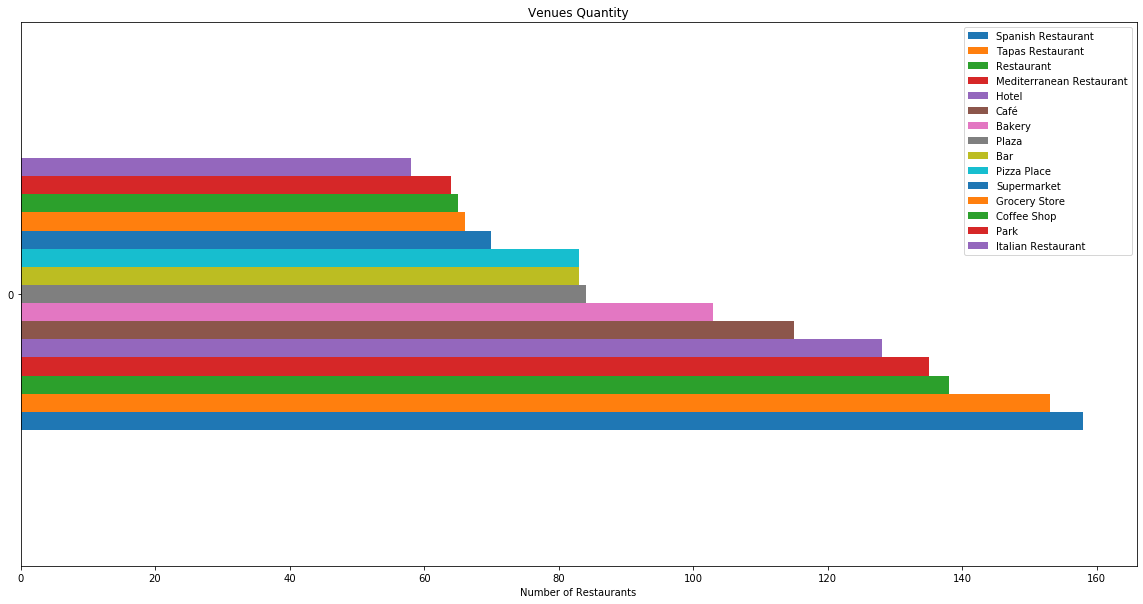

In [61]:
topnames.transpose().plot(kind='barh', 
             stacked=False,
             figsize=(20, 10), # pass a tuple (x, y) size
             )

plt.title('Venues Quantity')

plt.xlabel('Number of Restaurants')

plt.show()

### lets graph each cluster group

In [62]:
bcn_graph = bcn_sum2[top_columns]

In [63]:
bcn_graph['Group Type'] = ['High € zone','Mid € zone', 'Low € zone', ]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [64]:
column_fixer = list(bcn_graph.columns[-1:]) + list(bcn_graph.columns[:-1])
bcn_graph = bcn_graph[column_fixer]

In [65]:
bcn_graph

Group Type  Spanish Restaurant  Tapas Restaurant  Restaurant  \
0  High € zone                   7                 3           9   
1   Mid € zone                  84                69          71   
2   Low € zone                  67                81          58   

   Mediterranean Restaurant  Hotel  Café  Bakery  Plaza  Bar  Pizza Place  \
0                         5      3     8       1      5    0            1   
1                        87     86    59      55     36   41           48   
2                        43     39    48      47     43   42           34   

   Supermarket  Grocery Store  Coffee Shop  Park  Italian Restaurant  
0            6              7            3     7                   0  
1           19             17           31    29                  40  
2           45             42           31    28                  18

In [66]:
bcn_graph.set_index('Group Type', inplace = True)

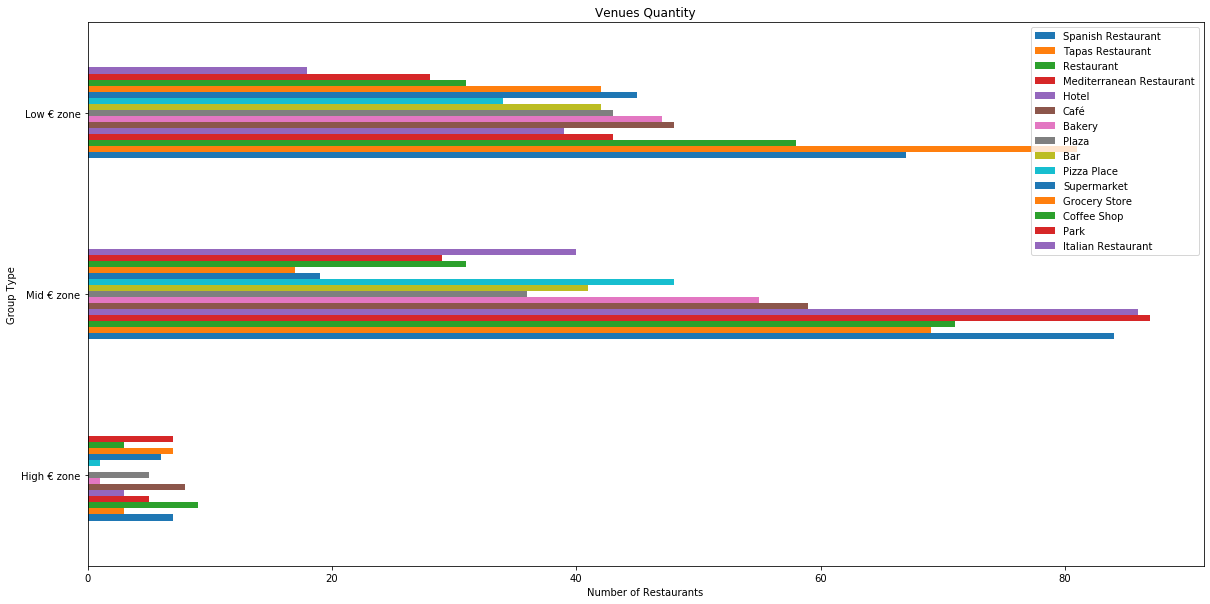

In [67]:
bcn_graph.plot(kind='barh', 
             stacked=False,
             figsize=(20, 10), # pass a tuple (x, y) size
             )

plt.title('Venues Quantity')

plt.xlabel('Number of Restaurants')

plt.show()

In [68]:
dist = whole.groupby('Districts').sum()
a = whole.groupby('Districts').mean()
dist['2019 Average m^2 price €'] = a['2019 Average m^2 price €']

In [69]:
bcn_sum3 = dist.drop(columns = ['Population 2018','2019 Average m^2 price €','Latitude','Longitude' ])
bcn_sum3.reset_index(inplace=True)

In [70]:
num_top_venues = num_venues

# name format for columns in new df
indicators = ['st', 'nd', 'rd']
columns = ['Districts']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#new df with columns for the last code
bcn_sum3name = pd.DataFrame(columns=columns)

bcn_sum3name['Districts'] = bcn_sum3['Districts']


#paste thae values from previous fx
for ind in np.arange(bcn_sum3.shape[0]):
    bcn_sum3name.iloc[ind, 1:] = common_venues(bcn_sum3.iloc[ind, :], num_top_venues)

In [71]:
bcn_sum3name.head()

Districts     1st Most Common Venue     2nd Most Common Venue  \
0  Ciutat Vella          Tapas Restaurant  Mediterranean Restaurant   
1      Eixample                     Hotel          Tapas Restaurant   
2        Gràcia  Mediterranean Restaurant                    Bakery   
3         Horta             Grocery Store                Restaurant   
4     Les Corts        Spanish Restaurant                      Café   

      3rd Most Common Venue     4th Most Common Venue 5th Most Common Venue  \
0                     Hotel              Cocktail Bar    Spanish Restaurant   
1                Restaurant  Mediterranean Restaurant                  Café   
2                       Bar                      Café        Scenic Lookout   
3        Spanish Restaurant          Tapas Restaurant                Bakery   
4  Mediterranean Restaurant                    Garden            Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                   Bar           Coffee Shop        Ice Cream Shop   
1           Coffee Shop                Bakery    Spanish Restaurant   
2                 Hotel            Restaurant         Grocery Store   
3        Breakfast Spot          Soccer Field                   Gym   
4           Supermarket                 Hotel           Pizza Place   

  9th Most Common Venue  ... 11th Most Common Venue 12th Most Common Venue  \
0    Italian Restaurant  ...             Restaurant         Breakfast Spot   
1           Pizza Place  ...                 Hostel           Burger Joint   
2           Pizza Place  ...         Breakfast Spot               Mountain   
3                  Café  ...         Scenic Lookout                 Hostel   
4        Soccer Stadium  ...   Gym / Fitness Center                 Bakery   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  \
0               Wine Bar            Pizza Place                  Beach   
1                    Gym           Cocktail Bar         Breakfast Spot   
2     Spanish Restaurant           Burger Joint       Tapas Restaurant   
3   Gym / Fitness Center            Supermarket                  Trail   
4            Coffee Shop           Tennis Court       Tapas Restaurant   

  16th Most Common Venue 17th Most Common Venue 18th Most Common Venue  \
0      Paella Restaurant               Beer Bar     Seafood Restaurant   
1         Sandwich Place                    Bar     Mexican Restaurant   
2    Japanese Restaurant                 Hostel         Sandwich Place   
3                    Bar                  Hotel            Coffee Shop   
4           Soccer Field                  Diner          Grocery Store   

          19th Most Common Venue 20th Most Common Venue  
0                   Dessert Shop                 Hostel  
1                       Beer Bar                 Bistro  
2            Arts & Crafts Store        Thai Restaurant  
3       Mediterranean Restaurant         Soccer Stadium  
4  Vegetarian / Vegan Restaurant                 Museum  

[5 rows x 21 columns]

In [72]:
District = bcn_sum3name.copy()

In [73]:
bcn_result = bcn_sum.copy()
bcn_result.iloc[:,1:] = 0
bcn_result = barrio.join(bcn_result.set_index('Barrios'), on='Barrios')
bcn_result.drop(columns=bcn_result.columns[3:(len(District.columns)+2)],inplace = True)
bcn_result.sort_index(inplace=True)

bcn_resultclust = bcn_result.copy()
bcn_resultclust.set_index(['Groups'],inplace =True)
bcn_resultclust.sort_index(inplace=True)

bcn_resultbarr = bcn_result.copy()
bcn_resultbarr.set_index(['Barrios'],inplace =True)
bcn_resultbarr.sort_index(inplace=True)

bcn_resultdist = bcn_result.copy()
bcn_resultdist.set_index(['Districts'],inplace =True)
bcn_resultdist.sort_index(inplace=True)


In [74]:
district_value = 0.7
cluster_value = 0.3
real_value = 1
position = District.columns[1:]

lista = sorted(np.arange(num_top_venues + 1),reverse = True)
lista.pop()


for head , times in zip(Cluster[position], lista):
    for value, c in zip(Cluster[head], Cluster['Groups']):
        #print(f' {times} {c} {head} {value} ')
        bcn_resultclust.at['0',value] = times * cluster_value

        
        
for head , times in zip(District[position], lista):
    for value, dist in zip(District[head], District['Districts']):
        #print(f' {dist} {value} {times} ----------------------- {head} ')
        bcn_resultdist.at[dist,value] = times * district_value

        
        
for head , times in zip(barrio[position], lista):
    for value, barr in zip(barrio[head], barrio['Barrios']):
        #print(f' {barr} {value} {times} ----------------------- {head} ')
        bcn_resultbarr.at[barr,value] = times * real_value




In [75]:
bcn_resultclust.sort_values('Barrios',inplace = True)
bcn_resultbarr.sort_values('Barrios',inplace = True)
bcn_resultdist.sort_values('Barrios',inplace = True)


bcn_resultclust.reset_index(inplace = True)
bcn_resultbarr.reset_index(inplace = True)
bcn_resultdist.reset_index(inplace = True)

bcn_resultclust.drop(columns=['Barrios','Districts','Groups'],inplace=True)
bcn_resultbarr.drop(columns=['Barrios','Districts','Groups'],inplace=True)
bcn_resultdist.drop(columns=['Barrios','Districts','Groups'],inplace=True)

bcn_result.sort_values('Barrios',inplace = True)
bcn_result.drop(columns = bcn_result.columns[3:], inplace=True)

info = bcn_result.copy()

In [76]:
result = bcn_resultdist + bcn_resultclust - bcn_resultbarr
bcn_result = pd.concat([bcn_result,result],axis = 1)
bcn_result.drop(columns = ['Districts','Groups'],inplace = True)

In [77]:
bcn_result.head()

Barrios  Accessories Store  \
0                                 Baró de Viver                  0   
1                                      Can Baró                  0   
2                                     Canyelles                  0   
3                              Ciutat Meridiana                  0   
4  Diagonal Mar i el Front Marítim del Poblenou                  0   

   African Restaurant  American Restaurant  Amphitheater  Antique Shop  \
0                   0                    0             0             0   
1                   0                    0             0             0   
2                   0                    0             0             0   
3                   0                    0             0             0   
4                   0                    0             0             0   

   Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  ...  \
0         0       0                 0                       0  ...   
1         0       0                 0                       0  ...   
2         0       0                 0                       0  ...   
3         0       0                 0                       0  ...   
4         0       0                 0                       0  ...   

   Video Game Store  Video Store  Vietnamese Restaurant  Wine Bar  Wine Shop  \
0                 0            0                      0         0          0   
1                 0            0                      0         0          0   
2                 0            0                      0         0          0   
3                 0            0                      0         0          0   
4                 0            0                      0         0          0   

   Winery  Wings Joint  Women's Store  Yoga Studio  Zoo  
0       0            0              0            0    0  
1       0            0              0            0    0  
2       0            0              0            0  -16  
3       0            0              0            0    0  
4       0            0              0            0    0  

[5 rows x 299 columns]

In [78]:
def common_venues_name(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


def common_venues_value(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.values[0:num_top_venues]


num_top_venues = num_venues

#format name for columns in new df
indicators = ['st', 'nd', 'rd']
columns = ['Barrios']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

#new df with columns for the last code
bcn_result_name = pd.DataFrame(columns=columns)
bcn_result_name['Barrios'] = bcn_result['Barrios']

bcn_result_name_value = pd.DataFrame(columns=columns)
bcn_result_name_value['Barrios'] = bcn_result['Barrios']



#paste thae values from previous fx to new df
for ind in np.arange(bcn_result.shape[0]):
    bcn_result_name.iloc[ind, 1:] = common_venues(bcn_result.iloc[ind, :], num_top_venues)

for ind in np.arange(bcn_result.shape[0]):
    bcn_result_name_value.iloc[ind, 1:] = common_venues_value(bcn_result.iloc[ind, :], num_top_venues) 
    
    
#Create a list with both name and value
bcn_endgame = pd.DataFrame(columns=columns)
bcn_endgame['Barrios'] = bcn_result['Barrios']
endgamelist = []
for ind, value, name in zip(np.arange(bcn_result.shape[0]), bcn_result_name_value[position], bcn_result_name[position]):
        for valor, nombre in zip(bcn_result_name_value[value],bcn_result_name[name]):
            cell = str(nombre)+','+' Score:' + str(valor)
            endgamelist.append(cell)
            

# Get the list to the DataFrame
i = 0
for column in bcn_endgame.columns[1:]:
    for row in np.arange(len(bcn_endgame)):    
    #for column in bcn_endgame.columns:
        bcn_endgame.at[row,column] = endgamelist[i]
        #print(f'{row}{column}')
        i +=1

        
        
bcn_endgame.drop('Barrios',axis = 1,inplace=True)
result = pd.concat([info,bcn_endgame],axis = 1)
result.set_index(['Districts', 'Groups', 'Barrios'],inplace=True)
result.sort_index(inplace=True)

In [89]:
result.loc['Ciutat Vella']

1st Most Common Venue  \
Groups Barrios                                                       
1      Sant Pere, Santa Caterina i la Ribera         Bar, Score:10   
       el Barri Gòtic                          Restaurant, Score:7   
       el Raval                                    Hotel, Score:12   
       la Barceloneta                              Hotel, Score:12   

                                                    2nd Most Common Venue  \
Groups Barrios                                                              
1      Sant Pere, Santa Caterina i la Ribera      Ice Cream Shop, Score:9   
       el Barri Gòtic                             Breakfast Spot, Score:6   
       el Raval                               Italian Restaurant, Score:8   
       la Barceloneta                              Cocktail Bar, Score:11   

                                             3rd Most Common Venue  \
Groups Barrios                                                       
1      Sant Pere, Santa Caterina i la Ribera  Coffee Shop, Score:9   
       el Barri Gòtic                               Beach, Score:4   
       el Raval                                Restaurant, Score:7   
       la Barceloneta                         Coffee Shop, Score:9   

                                                    4th Most Common Venue  \
Groups Barrios                                                              
1      Sant Pere, Santa Caterina i la Ribera  Italian Restaurant, Score:8   
       el Barri Gòtic                          Paella Restaurant, Score:3   
       el Raval                                   Breakfast Spot, Score:6   
       la Barceloneta                         Italian Restaurant, Score:8   

                                                5th Most Common Venue  \
Groups Barrios                                                          
1      Sant Pere, Santa Caterina i la Ribera    Burger Joint, Score:5   
       el Barri Gòtic                            Pizza Place, Score:2   
       el Raval                                     Wine Bar, Score:5   
       la Barceloneta                         Breakfast Spot, Score:6   

                                             6th Most Common Venue  \
Groups Barrios                                                       
1      Sant Pere, Santa Caterina i la Ribera     Wine Bar, Score:5   
       el Barri Gòtic                            Beer Bar, Score:2   
       el Raval                                     Beach, Score:4   
       la Barceloneta                            Wine Bar, Score:5   

                                                    7th Most Common Venue  \
Groups Barrios                                                              
1      Sant Pere, Santa Caterina i la Ribera               Beach, Score:4   
       el Barri Gòtic                         Seafood Restaurant, Score:2   
       el Raval                                Paella Restaurant, Score:3   
       la Barceloneta                             Ice Cream Shop, Score:2   

                                                    8th Most Common Venue  \
Groups Barrios                                                              
1      Sant Pere, Santa Caterina i la Ribera         Pizza Place, Score:4   
       el Barri Gòtic                         Spanish Restaurant, Score:1   
       el Raval                                         Beer Bar, Score:2   
       la Barceloneta                               Dessert Shop, Score:1   

                                                    9th Most Common Venue  \
Groups Barrios                                                              
1      Sant Pere, Santa Caterina i la Ribera  Spanish Restaurant, Score:3   
       el Barri Gòtic                                    Dog Run, Score:0   
       el Raval                               Seafood Restaurant, Score:2   
       la Barceloneta                                 Hot Spring, Score:0   

                            

In [79]:
result_to_graph = result.copy()
result_to_graph.drop(columns=result_to_graph.columns[5:],inplace = True)
loc = barcelona_test[['Barrios','Latitude', 'Longitude']]
result_to_graph.reset_index(inplace=True)
result_to_graph = pd.merge(result_to_graph, loc, on = 'Barrios')

result_to_graph['Barrios'] = result_to_graph['Barrios'].str.replace('\'','-')

In [82]:
#open geojason
with open('barrisfixed2.json') as json_data:
    barrio_data = json.load(json_data)

geolocator = Nominatim(user_agent="coursera")
    
location = geolocator.geocode('Barcelona, España')
latitude = location.latitude
longitude = location.longitude

map_bcn = folium.Map(location = [latitude,longitude], zoom_start = 12.5)

threshold_scale = np.linspace(plotjoin['Population 2018'].min(), plotjoin['Population 2018'].max(), 6, dtype=int)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] = threshold_scale[-1] + 1

map_bcn.choropleth(
    geo_data=barrio_data,
    data=barcelona_test,
    columns=['Barrios', 'Population 2018'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population 2018',
    reset = True
)




# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, district,one,two,three,four,five in zip(result_to_graph['Latitude'], result_to_graph['Longitude'], result_to_graph['Barrios'],
                                            result_to_graph['Groups'], result_to_graph['Districts'], result_to_graph['1st Most Common Venue'],
                                                 result_to_graph['2nd Most Common Venue'], result_to_graph['3rd Most Common Venue'],
                                                result_to_graph['4th Most Common Venue'],result_to_graph['5th Most Common Venue']):

    words = (f'{cluster} District: {district}, <br> Barrio: {poi} <br> Opportunity: <br> {one}  <br>  {two}  <br>  {three}  <br>  {four}  <br>  {five}')
    try:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup = words,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_bcn)
    except:
        pass

map_bcn